<a href="https://colab.research.google.com/github/nfaggian/record_linkage/blob/master/similarity_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Record linkage : Similarity metrics

In [3]:
%%capture dependency_log
!pip install jellyfish tqdm matplotlib

In [4]:
import itertools

import numpy as np
import pandas as pd
import tqdm

import jellyfish as jf
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, display_markdown, Markdown

## GCP authentication
- - - 

In [5]:
try: 
    from google.colab import auth
    auth.authenticate_user()
except:     
    try:
        import google.auth
        credentials, project = google.auth.default()
    except:
        raise Exception('Google cloud authentication required!')

/home/nfaggian/development/miniconda/envs/py3/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Repace the line below with the appropriate GCP project ID, otherwise dataset queries will not work.

In [6]:
%env GOOGLE_CLOUD_PROJECT=anz-pso-nfaggian

project_id = 'anz-pso-nfaggian'

env: GOOGLE_CLOUD_PROJECT=anz-pso-nfaggian


## Retrieve donor data

In [7]:
query = f"""
SELECT
  * 
FROM
  record_link.donors
WHERE MOD(ABS(FARM_FINGERPRINT(CAST(donor_id AS STRING))), 1000) = 0
"""

raw_donors = pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard')
raw_donors = raw_donors.sort_values(by='donor_id')
raw_donors.head()

/home/nfaggian/development/miniconda/envs/py3/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


,donor_id,last_name,first_name,address_1,address_2,city,state,zip,employer,occupation
220,404,1-28-07 cash deposits,None,None,None,None,il,None,None,None
548,422,12 congressional district afl-cio cope cont. fund,None,59 magnolia dr.,None,belleville,il,62221,None,None
295,616,1420 west lexington partnership,None,1420 west lexington partnership,None,chicago,il,60607,None,None
309,988,18th ward democratic org,None,8150 s kedzie ave,None,chicago,il,60652,None,None
300,2158,35th & indiana currency exchange,None,126 e. 35th street,None,chicago,il,60616,None,None


**Data preperation**
- - - 

In [9]:
def transform(record):
  """
  Perform some simple transformations on the record.
  """
  
  # combine the first and last name
  return {
      'donor_id': record.donor_id,
          'city': f"{record.city or ' '}".strip().lower(),
          'name': f"{record.first_name or ' '} {record.last_name or ' '}".strip().lower(),
       'address': f"{record.address_1 or ' '} {record.address_2 or ' '}".strip().lower(), 
         'state': f"{record.state or ' '}".strip().lower(),
           'zip': f"{record.zip or ' '}".strip().lower(),
    'occupation': f"{record.occupation or ' '}".strip().lower(),
      'employer': f"{record.employer or ' '}".strip().lower(),
     'is_person': record.first_name is not None }

In [10]:
donors = [] 
for row, record in tqdm.tqdm(raw_donors.iterrows(), total=raw_donors.shape[0]):
    donors.append(transform(record))
donors = pd.DataFrame(donors)
donors.head()

100%|██████████| 726/726 [00:00<00:00, 2088.13it/s]


,address,city,donor_id,employer,is_person,name,occupation,state,zip
0,,,404,,False,1-28-07 cash deposits,,il,
1,59 magnolia dr.,belleville,422,,False,12 congressional district afl-cio cope cont. fund,,il,62221
2,1420 west lexington partnership,chicago,616,,False,1420 west lexington partnership,,il,60607
3,8150 s kedzie ave,chicago,988,,False,18th ward democratic org,,il,60652
4,126 e. 35th street,chicago,2158,,False,35th & indiana currency exchange,,il,60616


## Comparing strings

In [11]:
test_set = ['nathan', 'naythan', 'fish', 'fhsi', 'akhiles', 'akhi']

data = []
for (a, b) in itertools.combinations(test_set, 2):
    data.append(
        {'a': a, 
         'b': b, 
         'levenshtein': jf.levenshtein_distance(a, b),
         'damerau distance': jf.damerau_levenshtein_distance(a,b),
         'jaro distance': jf.jaro_winkler(a,b),
         'phonetically similar': jf.match_rating_comparison(a, b)
         })
    
pd.DataFrame(data).sort_values('jaro distance', ascending=False)

,a,b,damerau distance,jaro distance,levenshtein,phonetically similar
0,nathan,naythan,1,0.961905,1,True
14,akhiles,akhi,3,0.914286,3,True
9,fish,fhsi,2,0.666667,2,True
13,fhsi,akhi,3,0.666667,3,False
4,nathan,akhi,4,0.611111,4,False
8,naythan,akhi,5,0.595238,5,False
12,fhsi,akhiles,5,0.595238,6,False
3,nathan,akhiles,6,0.539683,6,False
7,naythan,akhiles,7,0.523810,7,False
11,fish,akhi,4,0.500000,4,True


## Comparing donors (names and addresses)
- - -

For any two records in the donor dataset we can now observe where our (reduced) dataset looks similar and where it does not.

In [12]:
def comparator(record_a, record_b):
  """
  Compares one field to another, using a series of distance metrics.
  """
  return {
    'donor_id1': record_a.donor_id,
    'donor_id2': record_b.donor_id,
    # name
    'jaro_name': jf.jaro_winkler(record_a['name'], record_b['name']),
    'damerau_name': jf.damerau_levenshtein_distance(record_a['name'], record_b['name']),
    'phonetic_name': jf.match_rating_comparison(record_a['name'], record_b['name']),
    # address  
    'jaro_address': jf.jaro_winkler(record_a['address'], record_b['address']),
    'damerau_address': jf.damerau_levenshtein_distance(record_a['address'], record_b['address']),  
    'phonetic_address': jf.match_rating_comparison(record_a['address'], record_b['address']),  
  }


In [32]:
distance_table = []
for row_a, record_a in tqdm.tqdm(donors.iterrows(), total=donors.shape[0]):
      for row_b, record_b in donors.iterrows():
            distance_table.append(comparator(record_a, record_b)) 
distance_table = pd.DataFrame(distance_table)

100%|██████████| 726/726 [04:54<00:00,  2.41it/s]


In [20]:
distance_table = distance_table.sort_values(by='jaro_name', ascending=False)

### What do similar donors look like?

In [21]:
for _, row in distance_table.head(3).iterrows():

    pair = donors[(donors['donor_id'] == row.donor_id1) |  
                  (donors['donor_id'] == row.donor_id2)][['donor_id', 'name', 'address']]
    
    pair['jaro_name'] = row['jaro_name']
    pair['jaro_address'] = row['jaro_address']
    
    pair['damerau_name'] = row['damerau_name']
    pair['damerau_address'] = row['damerau_address']
    
    pair['phonetic_name'] = row['phonetic_name']
    pair['phonetic_address'] = row['phonetic_address']
    
    display(pair.reset_index())    

,index,donor_id,name,address,jaro_name,jaro_address,damerau_name,damerau_address,phonetic_name,phonetic_address
0,52,51171,caterpillar employees pac,100 n. e. adams,1.0,0.611681,0,20,True,True
1,53,51211,caterpillar employees pac,600 south second suite 101,1.0,0.611681,0,20,True,True


,index,donor_id,name,address,jaro_name,jaro_address,damerau_name,damerau_address,phonetic_name,phonetic_address
0,273,257166,planned parenthood votes illinois,107 w. cook,1.0,0.87037,0,7,True,True
1,274,257172,planned parenthood votes illinois,107 w. cook ste. f,1.0,0.87037,0,7,True,True


,index,donor_id,name,address,jaro_name,jaro_address,damerau_name,damerau_address,phonetic_name,phonetic_address
0,52,51171,caterpillar employees pac,100 n. e. adams,1.0,0.611681,0,20,True,True
1,53,51211,caterpillar employees pac,600 south second suite 101,1.0,0.611681,0,20,True,True


### What do dissimilar donors look like?

In [22]:
for _, row in distance_table.tail(3).iterrows():

    pair = donors[(donors['donor_id'] == row.donor_id1) |  
                  (donors['donor_id'] == row.donor_id2)][['donor_id', 'name', 'address']]
    
    pair['jaro_name'] = row['jaro_name']
    pair['jaro_address'] = row['jaro_address']
    
    pair['damerau_name'] = row['damerau_name']
    pair['damerau_address'] = row['damerau_address']
    
    pair['phonetic_name'] = row['phonetic_name']
    pair['phonetic_address'] = row['phonetic_address']
    
    display(pair.reset_index())    

,index,donor_id,name,address,jaro_name,jaro_address,damerau_name,damerau_address,phonetic_name,phonetic_address
0,197,183266,john wyma & assoc.,123 n. wacker dr suite 1600,0.0,0.636455,18,18,False,False
1,323,300824,stegertv,43 w. sauk trail,0.0,0.636455,18,18,False,False


,index,donor_id,name,address,jaro_name,jaro_address,damerau_name,damerau_address,phonetic_name,phonetic_address
0,11,13601,al's,6050 west cermak road,0.0,0.513095,14,19,False,False
1,277,262770,produce plus inc,8 greenwood ave,0.0,0.513095,14,19,False,False


,index,donor_id,name,address,jaro_name,jaro_address,damerau_name,damerau_address,phonetic_name,phonetic_address
0,33,33270,benesch,205 n michigan ave ste2400,0.0,0.412393,12,24,False,False
1,425,405715,david dunkin,830 tower rd,0.0,0.412393,12,24,False,False


### What does a (subset of) similarity matrix data look like?

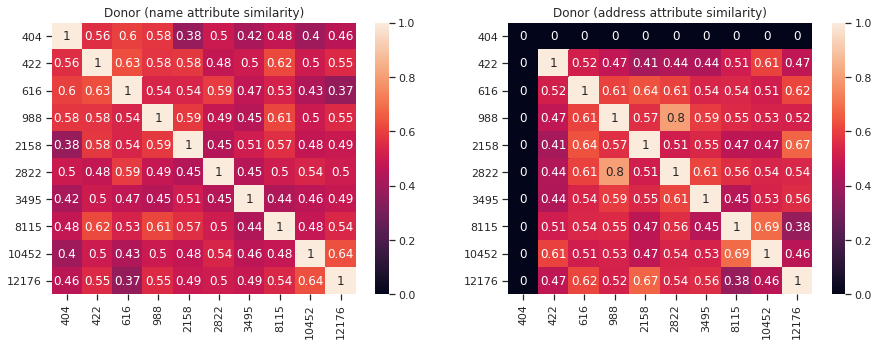

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

distance_matrix = distance_table.pivot('donor_id1', 'donor_id2', 'jaro_name')

sns.heatmap(distance_matrix.values[:10, :10], 
            annot=True, 
            vmin=0, 
            vmax=1, 
            yticklabels=distance_matrix.columns.values[:10],
            xticklabels=distance_matrix.columns.values[:10],
            ax=ax1)

ax1.set_title('Donor (name attribute similarity)')

distance_matrix = distance_table.pivot('donor_id1', 'donor_id2', 'jaro_address')

sns.heatmap(distance_matrix.values[:10, :10], 
            annot=True, 
            vmin=0, 
            vmax=1, 
            yticklabels=distance_matrix.columns.values[:10],
            xticklabels=distance_matrix.columns.values[:10],
            ax=ax2)

ax2.set_title('Donor (address attribute similarity)');